In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [2]:
def setup_all_seed(seed=0):
    np.random.seed(seed)  
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [3]:
train_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download = True)
test_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=False,
                                           transform=transforms.ToTensor(),
                                           download = True)

100%|███████████████████████████████████████████████████████████████████████████████| 9.91M/9.91M [00:00<00:00, 125MB/s]
100%|██████████████████████████████████████████████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 49.5MB/s]
100%|███████████████████████████████████████████████████████████████████████████████| 1.65M/1.65M [00:00<00:00, 154MB/s]
100%|██████████████████████████████████████████████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 9.64MB/s]


In [4]:
import matplotlib.pyplot as plt

fig : tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0

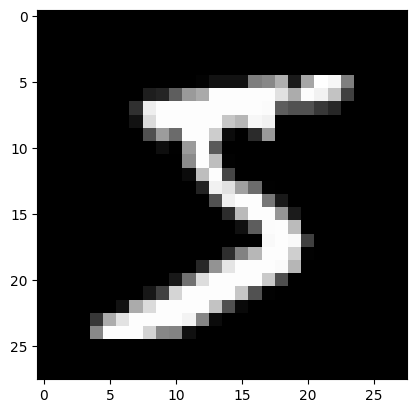

In [5]:
fig, label = train_dataset[0]
print("fig : {}, label : {}".format(fig,label))
print("fig.size() : {}".format(fig.size()))
plt.imshow(fig.view(-1,28), cmap='gray')

In [6]:
batch_size = 256

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

In [7]:
class Net(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.fc3 = nn.Linear(hidden2_size, output_size)

    def forward(self, x):
        z1 = F.relu(self.fc1(x))
        z2 = F.relu(self.fc2(z1))
        y = self.fc3(z2)
        return y

In [8]:
input_size = 28*28
hidden1_size = 1024
hidden2_size = 512
output_size = 10

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Net(input_size, hidden1_size, hidden2_size, output_size).to(device)
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
)


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [10]:
def train_model(model, train_loader, criterion, optimizer, device='cpu'):

    train_loss = 0.0
    num_train = 0

    model.train()

    for i, (images, labels) in enumerate(train_loader):
        num_train += len(labels)
        images, labels = images.view(-1, 28*28).to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss = train_loss / num_train

    return train_loss

In [11]:
def test_model(model, test_loader, criterion, optimizer, device='cpu'):

    test_loss = 0.0
    num_test = 0

    model.eval()

    with torch.no_grad(): 
        for i, (images, labels) in enumerate(test_loader):
            num_test += len(labels)
            images, labels = images.view(-1, 28*28).to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
        
        test_loss = test_loss / num_test
    return test_loss

In [12]:
def lerning(model, train_loader, test_loader, criterion, opimizer, num_epochs, device='cpu'):

    train_loss_list = []
    test_loss_list = []

    for epoch in range(1, num_epochs+1, 1):

        train_loss = train_model(model, train_loader, criterion, optimizer, device=device)
        test_loss = test_model(model, test_loader, criterion, optimizer, device=device)
        
        print("epoch : {}, train_loss : {:.5f}, test_loss : {:.5f}" .format(epoch, train_loss, test_loss))

        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)
    
    return train_loss_list, test_loss_list

In [13]:
num_epochs = 10
train_loss_list, test_loss_list = lerning(model, train_loader, test_loader, criterion, optimizer, num_epochs, device=device)

epoch : 1, train_loss : 0.00872, test_loss : 0.00845
epoch : 2, train_loss : 0.00731, test_loss : 0.00601
epoch : 3, train_loss : 0.00453, test_loss : 0.00345
epoch : 4, train_loss : 0.00288, test_loss : 0.00244
epoch : 5, train_loss : 0.00223, test_loss : 0.00199
epoch : 6, train_loss : 0.00191, test_loss : 0.00174
epoch : 7, train_loss : 0.00172, test_loss : 0.00163
epoch : 8, train_loss : 0.00159, test_loss : 0.00151
epoch : 9, train_loss : 0.00150, test_loss : 0.00141
epoch : 10, train_loss : 0.00143, test_loss : 0.00141


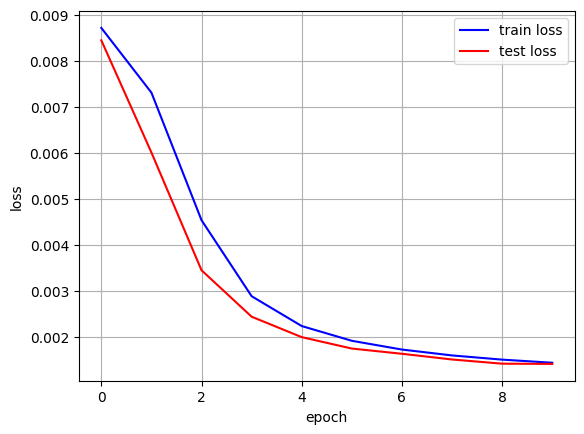

In [14]:
plt.plot(range(len(train_loss_list)), train_loss_list, c='b', label='train loss')
plt.plot(range(len(test_loss_list)), test_loss_list, c='r', label='test loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.grid()
plt.show()

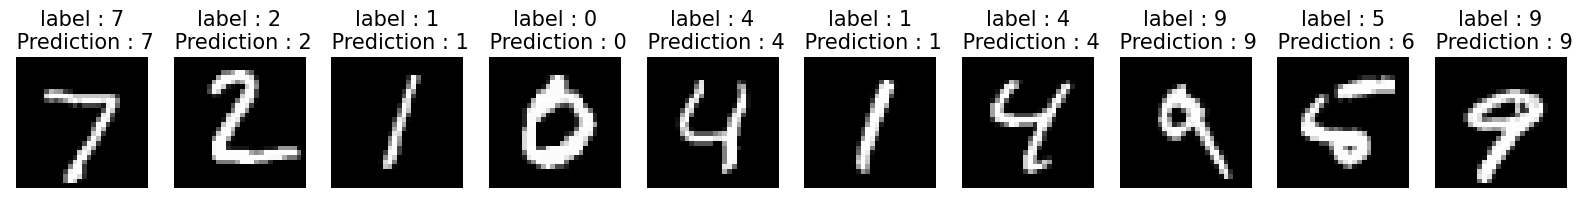

In [15]:
plt.figure(figsize=(20, 10))
for i in range(10):
    image, label = test_dataset[i]
    image = image.view(-1, 28*28).to(device)

    prediction_label = torch.argmax(model(image))

    ax = plt.subplot(1, 10, i+1)

    plt.imshow(image.detach().to('cpu').numpy().reshape(28, 28), cmap='gray')
    ax.axis('off')
    ax.set_title('label : {}\n Prediction : {}'.format(label, prediction_label), fontsize=15)
plt.show()